# AILAB4 – Bulaşık Makinesi için Bulanık Mantık (MMO makalesine dayalı)

**Amaç:** MMO’da yayımlanan *“Bulaşık Makinesinin Bulanık Mantık ile Modellenmesi”* makalesindeki yaklaşımı temel alarak
iki giriş (Kirlilik, Yük) ve iki çıkış (Yıkama Süresi, Su Sıcaklığı) içeren bir **Mamdani tip** bulanık kontrol sistemi kurmak ve örnek senaryoları simüle etmek.

**Kaynak:** Eğrisöğüt Tiryaki & Kazan, *Bulaşık Makinesinin Bulanık Mantık ile Modellenmesi*, Mühendis ve Makina, 48(565), 3–8. (MMO, PDF)  
**Not:** Bu defter, makaledeki metodolojiyi izleyen, pratikte uygulanabilir bir model sunar (küme sınırları tipik ev tipi bulaşık makinesi varsayımlarıyla belirlenmiştir). İstersen, üyelik aralıklarını cihazına/verine göre yeniden kalibre edebilirsin.



In [1]:
# Gerekli kütüphaneler
try:
    import skfuzzy as fuzz
    from skfuzzy import control as ctrl
except ModuleNotFoundError:
    # Jupyter'da çalışırken bir kerelik yüklemek için:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-fuzzy"])
    import skfuzzy as fuzz
    from skfuzzy import control as ctrl

import numpy as np
import matplotlib.pyplot as plt


## Değişkenler (Evren Aralıkları)
- **Kirlilik (0–100)**: Bulaşık suyu bulanıklığı/kirlilik düzeyi (sensör veya kullanıcı girişi).
- **Yük (0–12)**: Bulaşık yükü / set sayısı (0: boş, 12: çok dolu).

- **Yıkama Süresi (30–120 dk)**: Program süresi.
- **Su Sıcaklığı (35–70 °C)**: Yıkama suyu hedef sıcaklığı.

Bu aralıklar, ev tipi bulaşık makineleri için tipik aralıklardır. Üyelik kümeleri üçlü yapıdadır:
*düşük–orta–yüksek* (girişlerde) ve *kısa–normal–uzun* / *düşük–normal–yüksek* (çıkışlarda).


In [2]:
# 1) Evrenler
kirlilik = ctrl.Antecedent(np.arange(0, 101, 1), 'Kirlilik')        # 0..100
yuk      = ctrl.Antecedent(np.arange(0, 13, 1), 'Yuk')              # 0..12
sure     = ctrl.Consequent(np.arange(30, 121, 1), 'Sure')           # 30..120 (dk)
sicaklik = ctrl.Consequent(np.arange(35, 71, 1), 'Sicaklik')        # 35..70 (°C)

# 2) Üyelik fonksiyonları (trimf/trapmf)
# GİRİŞLER
kirlilik['dusuk']  = fuzz.trapmf(kirlilik.universe, [0, 0, 20, 35])
kirlilik['orta']   = fuzz.trimf(kirlilik.universe,  [25, 50, 75])
kirlilik['yuksek'] = fuzz.trapmf(kirlilik.universe, [60, 80, 100, 100])

yuk['az']     = fuzz.trapmf(yuk.universe, [0, 0, 2, 4])
yuk['orta']   = fuzz.trimf(yuk.universe,  [3, 6, 9])
yuk['fazla']  = fuzz.trapmf(yuk.universe, [8, 10, 12, 12])

# ÇIKIŞLAR
sure['kisa']   = fuzz.trapmf(sure.universe, [30, 30, 40, 55])
sure['normal'] = fuzz.trimf(sure.universe,  [50, 75, 100])
sure['uzun']   = fuzz.trapmf(sure.universe, [90, 105, 120, 120])

sicaklik['dusuk']  = fuzz.trapmf(sicaklik.universe, [35, 35, 40, 45])
sicaklik['normal'] = fuzz.trimf(sicaklik.universe,  [42, 52, 62])
sicaklik['yuksek'] = fuzz.trapmf(sicaklik.universe, [58, 63, 70, 70])


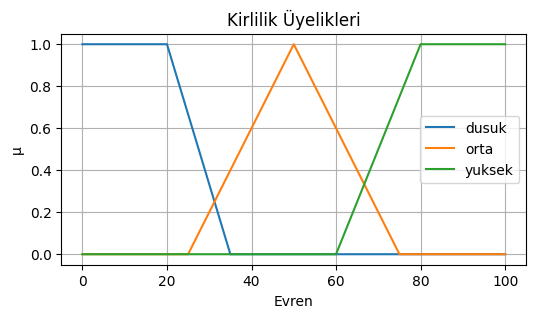

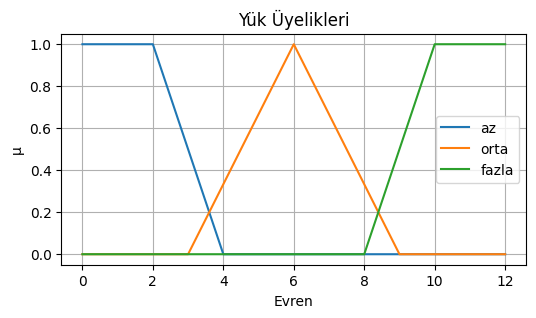

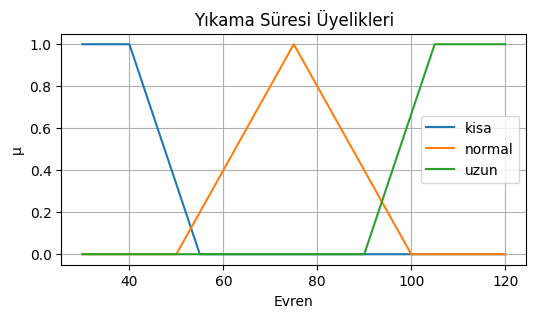

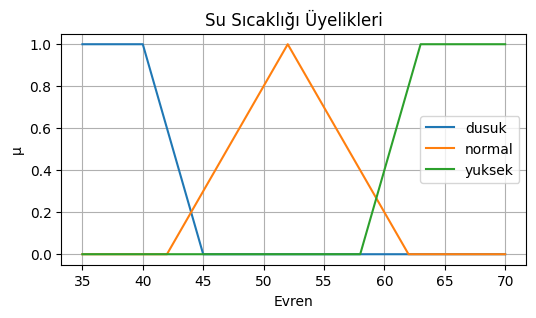

In [3]:
def plot_memberships(var, title):
    fig, ax = plt.subplots(figsize=(6,3))
    for term in var.terms:
        ax.plot(var.universe, var[term].mf, label=term)
    ax.set_title(title); ax.set_xlabel('Evren'); ax.set_ylabel('µ')
    ax.legend(loc='best'); ax.grid(True)
    plt.show()

plot_memberships(kirlilik, "Kirlilik Üyelikleri")
plot_memberships(yuk, "Yük Üyelikleri")
plot_memberships(sure, "Yıkama Süresi Üyelikleri")
plot_memberships(sicaklik, "Su Sıcaklığı Üyelikleri")


## Kural Tabanı (Mamdani)
Makaledeki yaklaşımı izleyerek ev tipi kullanım için sezgisel kurallar:

1. **Kirlilik yüksek** **veya** **Yük fazla** ise ⇒ **Süre = uzun**, **Sıcaklık = yüksek**  
2. **Kirlilik orta** ve **Yük orta** ise ⇒ **Süre = normal**, **Sıcaklık = normal**  
3. **Kirlilik düşük** **ve** **Yük az** ise ⇒ **Süre = kısa**, **Sıcaklık = düşük**  
4. **Kirlilik düşük** ve **Yük fazla** ise ⇒ **Süre = normal**, **Sıcaklık = normal**  
5. **Kirlilik yüksek** ve **Yük az** ise ⇒ **Süre = uzun**, **Sıcaklık = yüksek**  
6. **Kirlilik orta** ve **Yük fazla** ise ⇒ **Süre = uzun**, **Sıcaklık = yüksek**  
7. **Kirlilik düşük** ve **Yük orta** ise ⇒ **Süre = kısa**, **Sıcaklık = normal**  
8. **Kirlilik orta** ve **Yük az** ise ⇒ **Süre = normal**, **Sıcaklık = normal**  
9. (Kapsayıcılık için) **Kirlilik yüksek** ve **Yük orta** ⇒ **Süre = uzun**, **Sıcaklık = yüksek**

Kural 1 “yüksek gereksinim → agresif program” sezgisinin özetidir; 2–8 arası orta/düşük kombinasyonları dengeler.


In [4]:
rule1 = ctrl.Rule(kirlilik['yuksek'] | yuk['fazla'], (sure['uzun'], sicaklik['yuksek']))
rule2 = ctrl.Rule(kirlilik['orta'] & yuk['orta'], (sure['normal'], sicaklik['normal']))
rule3 = ctrl.Rule(kirlilik['dusuk'] & yuk['az'], (sure['kisa'], sicaklik['dusuk']))
rule4 = ctrl.Rule(kirlilik['dusuk'] & yuk['fazla'], (sure['normal'], sicaklik['normal']))
rule5 = ctrl.Rule(kirlilik['yuksek'] & yuk['az'], (sure['uzun'], sicaklik['yuksek']))
rule6 = ctrl.Rule(kirlilik['orta'] & yuk['fazla'], (sure['uzun'], sicaklik['yuksek']))
rule7 = ctrl.Rule(kirlilik['dusuk'] & yuk['orta'], (sure['kisa'], sicaklik['normal']))
rule8 = ctrl.Rule(kirlilik['orta'] & yuk['az'], (sure['normal'], sicaklik['normal']))
rule9 = ctrl.Rule(kirlilik['yuksek'] & yuk['orta'], (sure['uzun'], sicaklik['yuksek']))

system = ctrl.ControlSystem([rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9])
sim = ctrl.ControlSystemSimulation(system)


## Test 1
- **Kirlilik = 72**, **Yük = 9** (kirli ve dolu): *uzun ve sıcak bir program beklenir.*


Önerilen Yıkama Süresi (dk): 107.1
Önerilen Su Sıcaklığı (°C):  64.7


C:\Users\The Coder Farmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


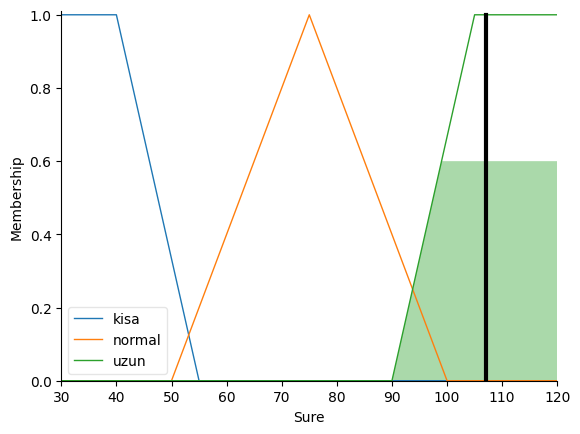

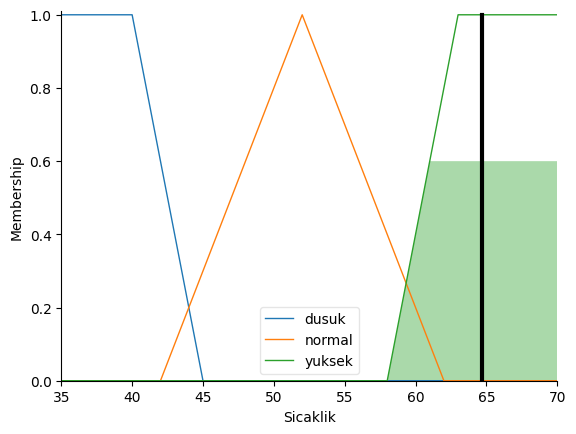

In [5]:
sim.input['Kirlilik'] = 72
sim.input['Yuk'] = 9
sim.compute()

print(f"Önerilen Yıkama Süresi (dk): {sim.output['Sure']:.1f}")
print(f"Önerilen Su Sıcaklığı (°C):  {sim.output['Sicaklik']:.1f}")

# Sonuçların görselleştirmesi
sure.view(sim=sim)
sicaklik.view(sim=sim)
plt.show()


## Izgara Taraması & Yüzey (Opsiyonel)
Aşağıda tüm giriş uzayı taranarak çıkışların ısı haritası çıkarılır. “Model, girişler artınca nasıl davranıyor?” sorusuna görsel yanıt verir.


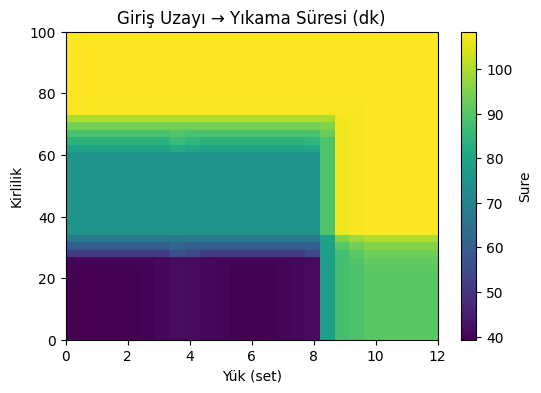

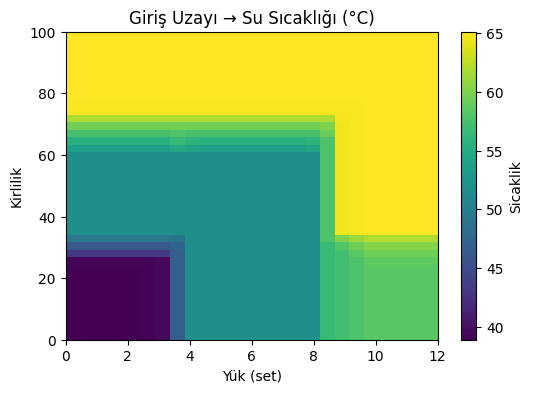

In [6]:
def scan_and_plot(output_name, title):
    k_vals = np.linspace(0, 100, 41)
    y_vals = np.linspace(0, 12, 25)
    Z = np.zeros((len(k_vals), len(y_vals)))

    for i, kv in enumerate(k_vals):
        for j, yv in enumerate(y_vals):
            sim.input['Kirlilik'] = kv
            sim.input['Yuk'] = yv
            sim.compute()
            Z[i, j] = sim.output[output_name]

    # Görselleştir
    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(Z, origin='lower',
                   extent=[y_vals.min(), y_vals.max(), k_vals.min(), k_vals.max()],
                   aspect='auto')
    ax.set_xlabel('Yük (set)'); ax.set_ylabel('Kirlilik')
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label=output_name)
    plt.show()

# Tarama
scan_and_plot('Sure', 'Giriş Uzayı → Yıkama Süresi (dk)')
scan_and_plot('Sicaklik', 'Giriş Uzayı → Su Sıcaklığı (°C)')


## TEST 2-3-4

| Senaryo | Kirlilik | Yük  | Beklenti        |
|-------- |--------  |------|---------------- |
| 2       | 15       | 3    | Kısa & Düşük    |
| 3       | 45       | 6    | Normal & Normal |
| 4       | 85       | 10   |  Uzun & Yüksek  |


In [7]:
def run_case(k, y):
    sim.input['Kirlilik'] = k
    sim.input['Yuk'] = y
    sim.compute()
    return sim.output['Sure'], sim.output['Sicaklik']

for (k,y) in [(15,3),(45,6),(85,10)]:
    s, t = run_case(k,y)
    print(f"Kirlilik={k:>3}, Yük={y:>2}  ->  Süre={s:5.1f} dk,  Sıcaklık={t:5.1f} °C")


Kirlilik= 15, Yük= 3  ->  Süre= 40.7 dk,  Sıcaklık= 39.4 °C
Kirlilik= 45, Yük= 6  ->  Süre= 75.0 dk,  Sıcaklık= 52.0 °C
Kirlilik= 85, Yük=10  ->  Süre=108.3 dk,  Sıcaklık= 65.1 °C


## Sonuçlar ve Ayar/Tuning İpuçları
- Model, **yüksek kirlilik / yüksek yük** durumunda “uzun ve sıcak” program öneriyor; düşük–az’da “kısa ve düşük”.
- **Kalibrasyon:** Kendi cihazın için sensör aralıkları farklıysa (örn. kirlilik 0–1 arası) evrenleri yeniden ölçeklendir. 
- **Defuzzification:** scikit-fuzzy varsayılanı **ağırlık merkezi (centroid)** yöntemidir; makaleye uygun (Mamdani) bir sonuç verir.
- **Kural ince ayarı:** Eğer “yük fazla ama kirlilik düşük” kullanıcı beklentisi kısa sürüyorsa, ilgili kuralı *kısa/normal* yöne çekebilirsin.


